<a href="https://colab.research.google.com/github/kattens/PubChem-Data-Handler/blob/main/Blast_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recap:

We have prepared a CSV file from an initial file named `cdot_targets`, containing PubChem IDs. For each PubChem ID, we searched PubChem to find interacting targets and documented these interactions in the "Target Names" column. Additionally, we included "Accession IDs," corresponding to UniProt IDs for each target, and a column for gene names to improve the accuracy of BLAST searches.

## Goal:

Our objective is to run BLAST searches using UniProt IDs from our CSV file against targets related to Plasmodium malaria.

## Tools and Libraries:

- **NCBIWWW**: Facilitates online BLAST searches.
- **NCBIXML**: Parses the XML results from BLAST into a manageable Python format.
- **SeqIO**: Utilized for reading and writing sequences across various bioinformatics file formats.

## Implementation:

Since the base code is operational, our next step is to save the data in a JSON file for each accession ID. This will allow us to manage and analyze the results efficiently.

## List of Plasmodium Variants on UniProt:

- **Plasmodium falciparum** - Taxon ID: 5833
- **Plasmodium malariae** - Taxon ID: 5858
- **Plasmodium vivax** - Taxon ID: 5855
- **Plasmodium ovale** - Taxon ID: 36330
- **Plasmodium berghei** - Taxon ID: 5821
- **Plasmodium reichenowi** - Taxon ID: 5854
- **Plasmodium gonderi** - Taxon ID: 77519
- **Plasmodium chabaudi** - Taxon ID: 5825

## Next Steps:

- Iterate through all UniProt IDs in the CSV file, perform a BLAST search for each, and store the results in a JSON file for subsequent analysis.


In [1]:
#install Bio
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.3 MB/s eta 0:00:00


In [21]:
import csv
import pandas as pd
from Bio.Blast import NCBIWWW,NCBIXML
from Bio import Entrez, SeqIO
import requests

In [3]:
path = '/content/drive/MyDrive/target_results.csv'
df = pd.read_csv(path)

In [4]:
df.head()

,PubChem ID,Target Names,Accession IDs,Target Gene Name
0,5330175,"['Tyrosineprotein', 'NTMT1', 'FH', 'Chain', 'N...","['A0A0K2VLS4', 'S4R3J7', 'P07954', 'P0C023', '...","['NTMT1', 'FH', 'NSD2', 'KDR', 'GPX4', 'COMT',..."
1,5311340,"['ID4', 'ALDH1A1', 'EZH2', 'MYC', 'GLA', 'APOB...","['P47928', 'Q5SYQ8', 'Q921E6', 'A0A8A5GQJ2', '...","['ID4', 'ALDH1A1', 'EZH2', 'MYC', 'GLA', 'APOB..."
2,11511120,"['AcylCoA', 'Epidermal', 'Mitogenactivated', '...","['B2BXS0', 'Q9Z0P7', 'L8GZV5', 'P05067', 'Q9ZN...","['NADH', 'MAP', 'CYP2C9', 'NSD2', 'ERBB4', 'GP..."
3,221354,"['CYP2D6', 'lethal', 'ALDH1A1', 'RGS12', 'ALOX...","['P10635', 'A1Z198', 'Q5SYQ8', 'E9Q652', 'I3L1...","['CYP2D6', 'ALDH1A1', 'RGS12', 'ALOX15B', 'HPG..."
4,6806409,[],[],[]


In [32]:
import requests
from Bio.Blast import NCBIWWW, NCBIXML

def fetch_uniprot_sequence(accession_id):
    """
    Fetch a sequence from UniProt using the accession ID.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{accession_id}.fasta"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            print(f"UniProt query failed for {accession_id} with status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error querying UniProt for {accession_id}: {e}")
        return None

def fetch_and_blast_sequence(accession_id, taxonomy, blast_db="nr",
                             blast_type="blastp", expect=0.1, matrix_name="BLOSUM62",
                             alignments=50, hitlist_size=50, filter="F", gapcosts="11 1"):
    """
    Fetch a sequence from UniProt, run BLAST, print and return results as a dictionary.
    """
    sequence_data = fetch_uniprot_sequence(accession_id)
    if not sequence_data:
        print(f"No sequence data found for Accession ID: {accession_id}")
        return None

    entrez_query = f"txid{taxonomy}[ORGN]"
    result_handle = NCBIWWW.qblast(blast_type, blast_db, sequence_data,
                                   expect=expect, matrix_name=matrix_name,
                                   alignments=alignments, hitlist_size=hitlist_size,
                                   filter=filter, gapcosts=gapcosts,
                                   entrez_query=entrez_query)

    blast_record = NCBIXML.read(result_handle)
    blast_results = []
    print(f"Results for Accession ID: {accession_id}")
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            result_detail = {
                "hit_id": alignment.hit_id,
                "hit_def": alignment.hit_def,
                "e_value": hsp.expect,
                "score": hsp.score,
                "query_align": hsp.query[:100],  # First 100 characters for example
                "subject_align": hsp.sbjct[:100]
            }
            blast_results.append(result_detail)

            # Print each result
            print(f"  Hit ID: {alignment.hit_id}")
            print(f"  Hit Description: {alignment.hit_def}")
            print(f"    E-value: {hsp.expect}")
            print(f"    Score: {hsp.score}")
            print(f"    Query Alignment: {hsp.query[:100]}...")
            print(f"    Subject Alignment: {hsp.sbjct[:100]}...")
            print("-" * 80)

    if blast_results:
        return blast_results
    else:
        print(f"No BLAST results found for Accession ID: {accession_id}")
        return None


#Explanation for the results:
**Hit ID**: This is a unique identifier for the sequence in the database that matched your query. In your example, emb|SBS97131.1| identifies the sequence in the database.

**Hit Description**: This provides more detailed information about the hit, including the name of the protein and the species. For instance, cdc2-related protein kinase 3, putative (CRK3) [Plasmodium malariae] tells you what the protein is and from which species it comes.

**E-value (Expectation value)**: This is a very important metric that describes the number of hits one can "expect" to see by chance when searching a database of a particular size. It’s a measure of the randomness of the match, where a lower E-value indicates a more significant match. An E-value of 0.00065012 suggests that the hit is quite significant.

**Score**: This is the computed score of the alignment, which takes into account the scoring matrix used in the analysis (like BLOSUM62, PAM250, etc.). Higher scores generally indicate better alignments.

**Query Alignment and Subject Alignment**: These are the actual sequences from your query and the database that align with each other. These give you a visual insight into how similar the query sequence is to the database sequence.

In [41]:
# Example usage
fetch_and_blast_sequence("P10635", 5833)

Results for Accession ID: P10635
No BLAST results found for Accession ID: P10635


In [33]:
# Example usage
fetch_and_blast_sequence("L8GZV5", 5858)

Results for Accession ID: L8GZV5
  Hit ID: emb|SBT71238.1|
  Hit Description: mitogen-activated protein kinase 2, putative [Plasmodium malariae]
    E-value: 1.82339e-41
    Score: 388.0
    Query Alignment: RLTDLYDLQHVIGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSSPHILAIHDLVPAMAEGKEEGEEEAVTMHNFRDLYVV...
    Subject Alignment: RVPDNYEIKHLIGRGSYGYVYLAYDKNTNKNVAIKKVNRMFEDLIDCKRILREITILN--RLNSDYVIRLCDLVVPE------------DLLKFDELYIV...
--------------------------------------------------------------------------------
  Hit ID: ref|XP_028861557.1|
  Hit Description: mitogen-activated protein kinase 2, putative [Plasmodium malariae] >emb|SBS85304.1| mitogen-activated protein kinase 2, putative (MAPK2) [Plasmodium malariae] >emb|SCN12660.1| mitogen-activated protein kinase 2, putative [Plasmodium malariae]
    E-value: 3.36172e-41
    Score: 387.0
    Query Alignment: RLTDLYDLQHVIGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSSPHILAIHDLVPAMAEGKEEGEEEAVTMHNFRDLYVV...
    Subject Alignment

[{'hit_id': 'emb|SBT71238.1|',
  'hit_def': 'mitogen-activated protein kinase 2, putative [Plasmodium malariae]',
  'e_value': 1.82339e-41,
  'score': 388.0,
  'query_align': 'RLTDLYDLQHVIGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSSPHILAIHDLVPAMAEGKEEGEEEAVTMHNFRDLYVV',
  'subject_align': 'RVPDNYEIKHLIGRGSYGYVYLAYDKNTNKNVAIKKVNRMFEDLIDCKRILREITILN--RLNSDYVIRLCDLVVPE------------DLLKFDELYIV'},
 {'hit_id': 'ref|XP_028861557.1|',
  'hit_def': 'mitogen-activated protein kinase 2, putative [Plasmodium malariae] >emb|SBS85304.1| mitogen-activated protein kinase 2, putative (MAPK2) [Plasmodium malariae] >emb|SCN12660.1| mitogen-activated protein kinase 2, putative [Plasmodium malariae]',
  'e_value': 3.36172e-41,
  'score': 387.0,
  'query_align': 'RLTDLYDLQHVIGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSSPHILAIHDLVPAMAEGKEEGEEEAVTMHNFRDLYVV',
  'subject_align': 'RVPDNYEIKHLIGRGSYGYVYLAYDKNTNKNVAIKKVNRMFEDLIDCKRILREITILN--RLNSDYVIRLCDLVVPE------------DLLKFDELYIV'},
 {'hit_id': 'e

In [35]:
# Example usage
fetch_and_blast_sequence("E9Q652", 5858)


Results for Accession ID: E9Q652
No BLAST results found for Accession ID: E9Q652


In [37]:
fetch_and_blast_sequence("B2BXS0", 5858)

Results for Accession ID: B2BXS0
No BLAST results found for Accession ID: B2BXS0


In [38]:
fetch_and_blast_sequence("P07954", 5858)

Results for Accession ID: P07954
No BLAST results found for Accession ID: P07954


In [34]:
'''
mechanism: loop through each taxon_id and for them do the blast search of each accession id and save the results in a json file
 - we should also have the name of the json file of the result to be the taxon id and then have the results that shows each accession id
  and the returned result

'''
import json
import os

folder_path = '/content/drive/MyDrive/jsonfolder'
os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists

# Example species and accession IDs for debugging
taxon_ids = [5858]  # Use a small subset for testing
ids = ['L8GZV5','E9Q652']  # Known accession ID for testing

for taxon_id in taxon_ids:
    print(f"Processing taxonomy ID: {taxon_id}")
    taxon_results = {}

    for accession_id in ids:
        print(f"Processing Accession ID: {accession_id}")
        result = fetch_and_blast_sequence(accession_id, taxonomy=taxon_id)

        if result:
            taxon_results[accession_id] = result
        else:
            print(f"No results returned for Accession ID: {accession_id}")

    json_filename = os.path.join(folder_path, f"{taxon_id}.json")
    with open(json_filename, "w") as f:
        json.dump(taxon_results, f, indent=4)

    print(f"BLAST results saved to '{json_filename}'.")


Processing taxonomy ID: 5858
Processing Accession ID: L8GZV5
Results for Accession ID: L8GZV5
  Hit ID: emb|SBT71238.1|
  Hit Description: mitogen-activated protein kinase 2, putative [Plasmodium malariae]
    E-value: 1.82339e-41
    Score: 388.0
    Query Alignment: RLTDLYDLQHVIGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSSPHILAIHDLVPAMAEGKEEGEEEAVTMHNFRDLYVV...
    Subject Alignment: RVPDNYEIKHLIGRGSYGYVYLAYDKNTNKNVAIKKVNRMFEDLIDCKRILREITILN--RLNSDYVIRLCDLVVPE------------DLLKFDELYIV...
--------------------------------------------------------------------------------
  Hit ID: ref|XP_028861557.1|
  Hit Description: mitogen-activated protein kinase 2, putative [Plasmodium malariae] >emb|SBS85304.1| mitogen-activated protein kinase 2, putative (MAPK2) [Plasmodium malariae] >emb|SCN12660.1| mitogen-activated protein kinase 2, putative [Plasmodium malariae]
    E-value: 3.36172e-41
    Score: 387.0
    Query Alignment: RLTDLYDLQHVIGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSS

# How to Filter for the Top 10 Most Similar Sequences

To filter for the top 10 most similar sequences based on these results, you generally want to sort your results by either the lowest E-values or the highest scores, as both are strong indicators of similarity. Lower E-values are often more informative as they directly relate to the likelihood of the match occurring by chance.

In [39]:
def sort_and_save_top_results(json_file_path, output_file_path=None, top_n=10):
    """
    Read BLAST results from a JSON file, sort them by E-value, and save the top results.

    Args:
    json_file_path (str): Path to the JSON file containing the BLAST results.
    output_file_path (str): Path to save the sorted results. If None, overwrite the original file.
    top_n (int): Number of top results to save.
    """
    # Read the existing JSON file
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Sort the results for each accession ID
    for accession_id, results in data.items():
        sorted_results = sorted(results, key=lambda x: x['e_value'])[:top_n]
        data[accession_id] = sorted_results

    # Determine output file path
    if output_file_path is None:
        output_file_path = json_file_path

    # Save the sorted results to a JSON file
    with open(output_file_path, 'w') as file:
        json.dump(data, file, indent=4)

    print(f"Top {top_n} BLAST results saved to '{output_file_path}'.")


In [40]:
# Example
json_file_path = '/content/drive/MyDrive/jsonfolder/5858.json'
output_file_path = '/content/drive/MyDrive/jsonfolder/5858_sorted.json'
#get results
sort_and_save_top_results(json_file_path, output_file_path)


Top 10 BLAST results saved to '/content/drive/MyDrive/jsonfolder/5858_sorted.json'.


#Plot the results based on score and e-value

In [49]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_and_prepare_data(json_file_path):
    """
    Load JSON data and prepare it for plotting.
    Returns a DataFrame with 'hit_description', 'score', and 'e_value' columns.
    """
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    rows = []
    for accession_id, results in data.items():
        for result in results:
            rows.append({
                "accession_id": accession_id,
                "hit_description": result["hit_def"],
                "score": result["score"],
                "e_value": result["e_value"]
            })
    return pd.DataFrame(rows)

def plot_scores(df):
    """
    Plot the BLAST results focusing on scores.
    """
    plt.figure(figsize=(14, 10))  # Larger figure size
    scores = df['score']
    descriptions = df.index  # Use numerical index for clarity

    plt.barh(descriptions, scores, color='dodgerblue')
    plt.xlabel('Score')
    plt.title('BLAST Hit Scores')
    plt.yticks(descriptions, df['hit_description'].apply(lambda x: x.split(' [')[0]))  # Apply labels here
    plt.grid(True)
    plt.tight_layout()

    plt.show()

def plot_e_values(df):
    """
    Plot the BLAST results focusing on E-values.
    """
    plt.figure(figsize=(14, 10))  # Larger figure size
    e_values = -np.log10(df['e_value'])
    descriptions = df.index  # Use numerical index for clarity

    plt.barh(descriptions, e_values, color='tomato')
    plt.xlabel('-Log10(E-value)')
    plt.title('BLAST Hit E-values')
    plt.yticks(descriptions, df['hit_description'].apply(lambda x: x.split(' [')[0]))  # Apply labels here
    plt.grid(True)
    plt.tight_layout()

    plt.show()



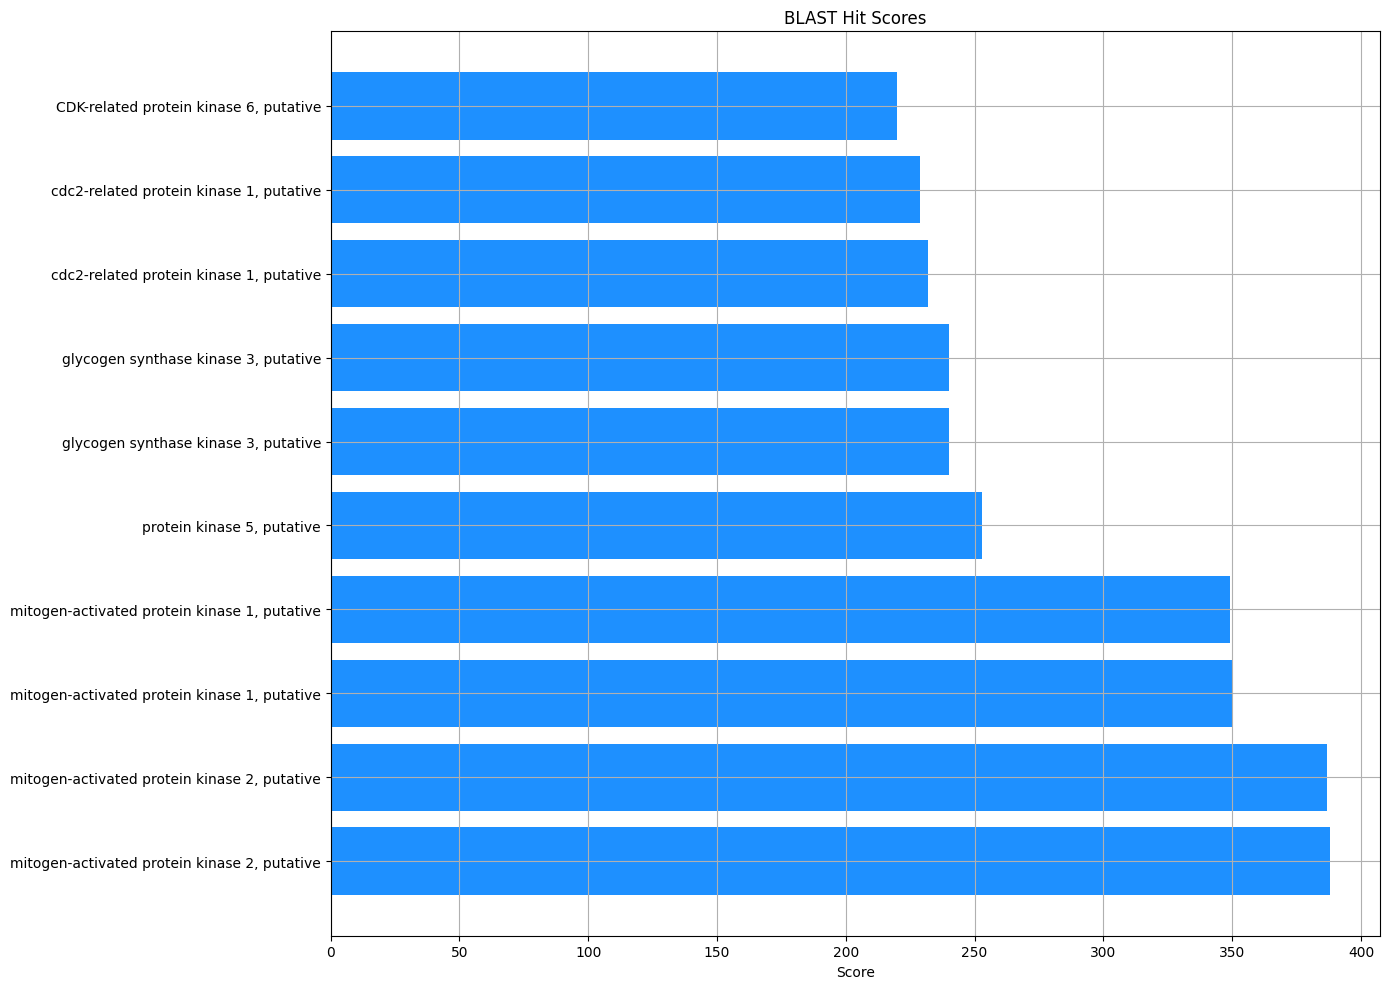

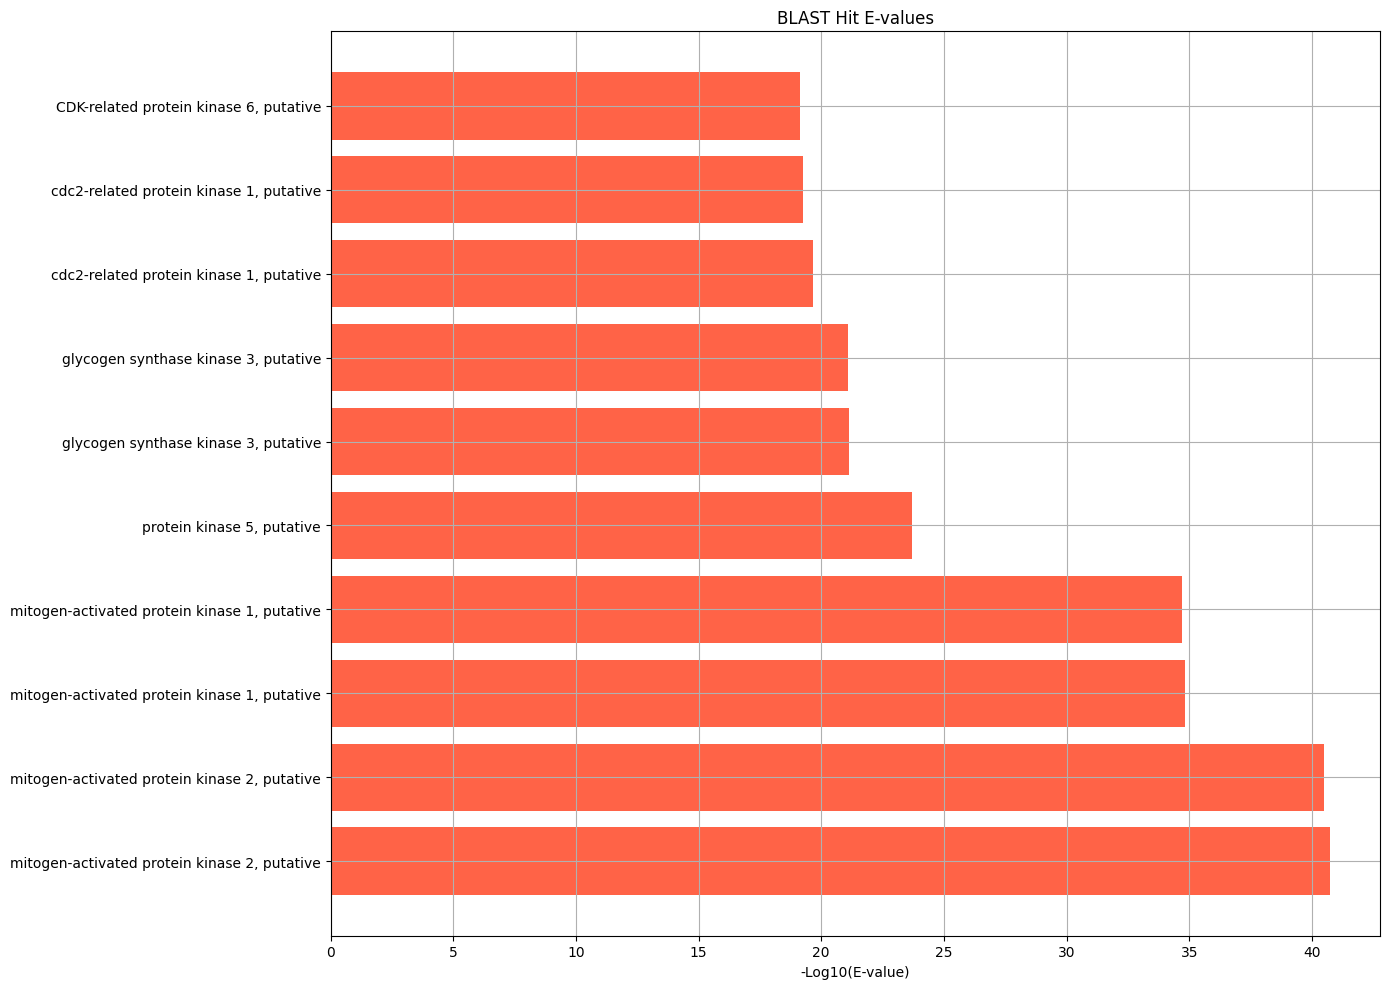

In [50]:
# Example usage
json_file_path = '/content/drive/MyDrive/jsonfolder/5858_sorted.json'
df = load_and_prepare_data(json_file_path)
plot_scores(df)
plot_e_values(df)


## Next Steps for Refining BLAST Search Parameters

As we progress with our analysis and based on initial results, consider the following modifications to the BLAST search parameters to optimize performance and relevance of the results:

1. **E-value Threshold**:
   - **Consider lowering the `expect` value** to 0.01 or even 0.001 to focus on more statistically significant hits, reducing the noise from less significant matches.

2. **Enable Filtering**:
   - **Enable the low-complexity filter** (`filter="T"`) to help avoid non-specific matches in low-complexity regions or repetitive sequences.

3. **Substitution Matrix**:
   - **Evaluate the use of different matrices** such as PAM30 or BLOSUM80, depending on the evolutionary distances expected among the proteins being studied.

4. **Limiting Results**:
   - **Reduce `alignments` and `hitlist_size`** to 20 or even 10 to concentrate on the most relevant hits, minimizing clutter from redundant or less relevant data.

5. **Database Selection**:
   - **Consider switching to a curated database** like SwissProt for queries where quality and annotation reliability are paramount, as it has less redundancy than the nr database.

6. **Taxonomic Filtering**:
   - **Use the `entrez_query` parameter** to narrow down searches to specific taxonomic groups if the study is focused on particular organisms or taxa.

These suggestions are intended to be tested iteratively. Adjustments should be made based on the specific requirements of your research and the results obtained from preliminary searches.
